## Monte carlo localization for 1D discrete-motion Robot with uncertainities

  * Robot moves in one-dimension discrete track that is 100 meters long. 
  * At each time step the robot position is discrete and can change only by 1 meter. 
  * The robot moves 1 meter at each time step. 
    * Because of slip and friction 5% of the time it moves 2 meters, 5% it does not move and 90% it moves 1 meter.
    * These values are used in the update kernel as $[move_0, move_1, move_2] = [0.05, 0.9, 0.05]$
  * The Robot is equipped with a GPS that measures the location. 
    * The sensor measures the correct location for 90% of the time and 10% of the time it gives the wrong location.

  * The robot starts at the very left (at time=0) (the robot does not know this) and then travels one 1m at each time step for 50 time steps. 

  To estimate the belief for the robot after $T$ time steps input time in *time_step* and run the *train_filter*.

In [ ]:
%pip install filterpy

In [ ]:
%matplotlib inline

from filterpy.discrete_bayes import discrete_bayes, normalize, predict, update
import numpy as np
import matplotlib.pyplot as plt
import random

plt.rcParams['figure.figsize'] = [15, 1.5]

In [ ]:
class Robot(object):
    ''' Robot Model '''

    def __init__(self, track_length, kernel=[1.], sensor_accuracy=.9):
        self.track_len = track_length
        self.pos = 0
        self.kernel = kernel
        self.sensor_accuracy = sensor_accuracy

    def move(self, distance=1):
        """ Movement in the specified direction with a chance of error"""

        self.pos += distance
        ''' Assigning random movement according to kernel probabilities '''
        r = random.random()
        s = 0
        offset = -(len(self.kernel) - 1) / 2  #Determine the move step (= 1 in this case)
        for k in self.kernel:
            s += k
            if r <= s:
                break
            offset += 1
        self.pos = int((self.pos + offset) % self.track_len)
        return self.pos

    def sense(self):
        ''' Estimation for the GPS '''

        pos = self.pos
        ''' Randomized sensor error '''
        if random.random() > self.sensor_accuracy:
            if random.random() > 0.5:
                pos += 1
            else:
                pos -= 1
        return pos

In [ ]:
def position_likelihood(track, measurement, sensor_accuracy):
    """ Function to compute the likelihood that a measurement matches actual positions """
    
    try:
        scale = sensor_accuracy / (1. - sensor_accuracy)
    except ZeroDivisionError:
        scale = 1e8

    likelihood = np.ones(len(track))
    likelihood[track==measurement] *= scale
    return likelihood

def train_filter(iterations, kernel, sensor_accuracy, 
             move_distance, do_print=True, robot_history=True):
  
    """ Path for the Robot """
    track = np.arange(100)

    """ Prior probability for Robot Position """
    prior = np.array([sensor_accuracy] + [int((1-sensor_accuracy)/len(track))]*99)
    posterior = prior[:]
    normalize(prior)
    
    robot = Robot(len(track), kernel, sensor_accuracy)
    for i in range(iterations):
        ''' Movement of the robot '''
        robot.move(distance=move_distance)

        ''' Prediction step '''
        prior = predict(posterior, move_distance, kernel)       

        '''  Filter update step '''
        measurement = robot.sense()
        likelihood = position_likelihood(track, measurement, sensor_accuracy)
        posterior = update(likelihood, prior)
        index = np.argmax(posterior)

        if do_print and robot_history:
            print(f'time {i}: pos {robot.pos}, sensed {measurement}, at position {track[robot.pos]}')
            conf = posterior[index] * 100
            print(f'          estimated position is {index} with confidence {conf:.4f}%')

    if do_print:
        print()
        print('''At time {}, final position is {}'''.format(iterations-1, robot.pos))
        index = np.argmax(posterior)
        print('''Estimated position is {} with confidence {:.4f}%'''.format(index, posterior[index]*100))
    
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    ax.bar(track, posterior)
    ax.set_ylabel('beleif')
    ax.set_xlabel('Position')
    ax.set_title(f'Belief of Robot position at time {i}')
    plt.show()

    # return posterior

    


At time 3, final position is 4
Estimated position is 4 with confidence 98.6221%


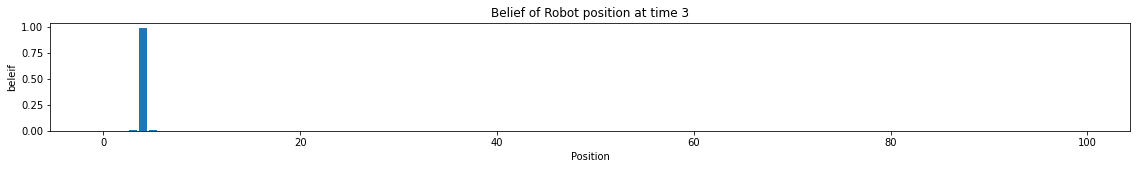


At time 6, final position is 6
Estimated position is 7 with confidence 31.6941%


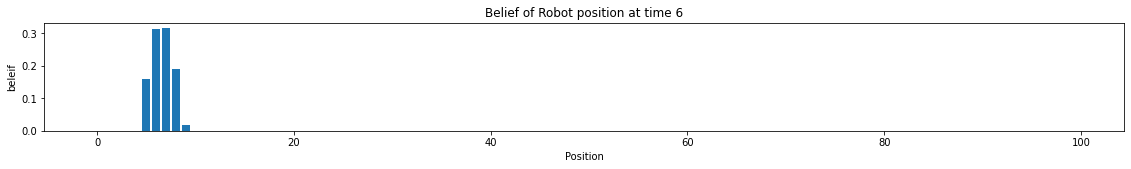


At time 10, final position is 11
Estimated position is 11 with confidence 96.4174%


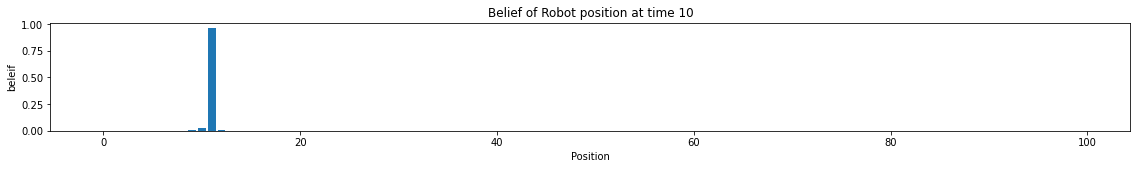


At time 50, final position is 48
Estimated position is 48 with confidence 98.5906%


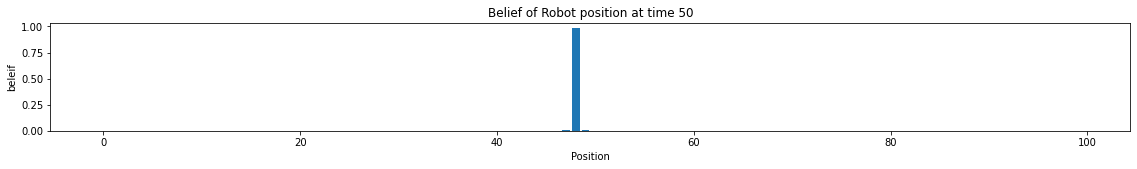

In [ ]:
''' Track specifications and Robot specifications '''
track = np.arange(0,100)
move_0 = 0.05
move_1 = 0.9
move_2 = 0.05
sensor_accuracy = 0.9

#Probability of robot movement
kernel = [move_0, move_1, move_2]


random.seed(1)

#Times for estimating Robot movement (time starts at 0 when the Robot is at position 1)
time_step = 3
train_filter(time_step+1, kernel, sensor_accuracy=.9, move_distance=1, do_print=True, robot_history=False)

time_step = 6
train_filter(time_step+1, kernel, sensor_accuracy=.9, move_distance=1, do_print=True, robot_history=False)

time_step = 10
train_filter(time_step+1, kernel, sensor_accuracy=.9, move_distance=1, do_print=True, robot_history=False)

time_step = 50
train_filter(time_step+1, kernel, sensor_accuracy=.9, move_distance=1, do_print=True, robot_history=False)

# References

* https://github.com/rlabbe/filterpy

* https://github.com/rlabbe/Kalman-and-Bayesian-Filters-in-Python
